# Tutorial on ebcpy

Assume the following situation.
From an experiment we have gathered following data:
<img src="tutorial/measured_data.png">
We want to use the data as an input to a simulation. However, as visible, the data is noisy and thus may lead to instability of our simulation.

First we will load modules supporting this tutorial:

In [16]:
import os
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Data Types
Let's specify the path to our measurement data and load it.    

In [17]:
from ebcpy import data_types
# Specify the path to the measured data:
path = os.path.join(os.getcwd(), "tutorial", "measuredData.hdf")
try:
    data_types.TimeSeriesData(path)
except KeyError as e:
    print(e)

'key must be provided when HDF5 file contains multiple datasets. Here are all keys in the given hdf-file: other test, test'


**Why did we expect the error?** One hdf-file can store multiple tables.
In this case, 'other test' was stored as-well.

The error shows the options you have, 'other test' or 'test'.
Same applies for other file-formats. '.csv' needs the seperator (`sep`),
and '.xlsx' the name of the sheet (`sheet_name`) as a keyword-argument.

'test' holds in this case the correct data:

Variables            measured_T
Tags                        raw
Time                           
2019-12-21 14:10:03  293.764306
2019-12-21 14:10:04  294.581815
2019-12-21 14:10:05  294.757593
2019-12-21 14:10:06  294.236406
2019-12-21 14:10:07  294.995937
...                         ...
2019-12-21 15:10:00  305.029739
2019-12-21 15:10:01  306.215838
2019-12-21 15:10:02  305.805173
2019-12-21 15:10:03  306.255180
2019-12-21 15:10:03  305.630872

[3610 rows x 1 columns]


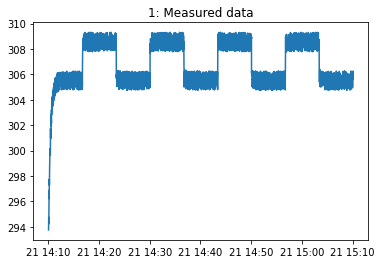

In [18]:
tsd = data_types.TimeSeriesData(path, key="test")
print(tsd)
plt.plot(tsd["measured_T"])
plt.title("1: Measured data")
plt.show()

If you're familiar with `python` and `DataFrames`, you will ask  yourself: **Why do I need the TimeSeriesData-Class?** We implemented this class to combine the powerful `pandas.DataFrame` class with new functions for an easy usage in the context of Building Energy Systems for three main reasons:
- Most data in our case is Time-Dependend, therefore functions for easy conversion between seconds (for Simulation) and Timestamps (for measurements) is needed 
- Most data is stored in files. Typically .hdf and .mat is used, .csv and even .xlsx files occur frequently. Pandas has different functions (`from_hdf`, `from_csv`) and no at all function for loading Modelica-Result files.
- Working with energy related data, you most likely are interested in understanding where a value comes from. For this reason we base the TimeSeriesData-Class on the pandas MultiColumn-Feature. Every variable (e.g. Temperature) will get tags for specific reasons. The default being "raw", assuming that data loaded from a file without tags most likely is unprocessed.

Note how the loaded measurement got the tag 'raw'. Else not much new, just DataFrame. Let's adjust the noisy data for the usage in a simulation tool like Modelica.

For this reason, we load the preprocessing module of `ebcpy`. 

# Preprocessing

We want to manipulate only the values in the DataFrame. Therefore we need to first extract the data. We use numpy as a return type, as most preprocessing functions like filters run on numpy-arrays. 

In [19]:
from ebcpy import preprocessing
# Extract the column of interest to get the trajectory or array for processing
trajectory = tsd.get_columns_by_tag("raw", columns=["measured_T"], return_type="numpy")
print(trajectory)

[[293.76430587]
 [294.58181461]
 [294.75759264]
 ...
 [305.80517346]
 [306.25517972]
 [305.63087246]]


We then can apply either a filter or a moving-average. To further understand differences between both options, adjust the parameters in the box below and rerun the cell. You will see how the output changes. Which function you use for your data is up to you, a general appraisal cannot be made.

**Note**: The syntax for values for an existing variable with a new tag, you have to call:
```python
tsd[VARIABLE_NAME, NEW_TAG_NAME] = VALUES
```
In this case: 

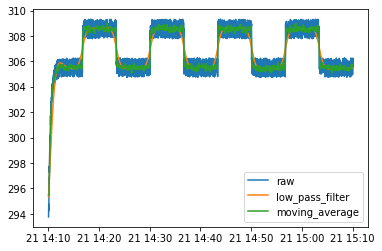

In [20]:
tsd["measured_T", "low_pass_filter"] = preprocessing.low_pass_filter(data=trajectory, 
                                                                     crit_freq=0.01, 
                                                                     filter_order=2)
tsd["measured_T", "moving_average"] = preprocessing.moving_average(data=trajectory, 
                                                                   window=10)
# Plot the values
plt.plot(tsd["measured_T"])
plt.legend(tsd["measured_T"].columns.values)
plt.show()

Now let's assume we want to know when to turn on a certain device based on our measurements. Looking at our data, we know some device turned on or off, if the temperature rises above some 34 °C. To reproduce the signal for our simulation, we can use the `create_on_off_signal` method. For this example we use the default tag "raw", however you may also try "moving_average" or other created tags.

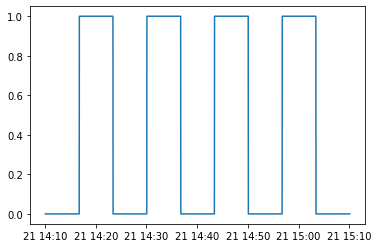

In [21]:
plt.close()
tsd = preprocessing.create_on_off_signal(df=tsd,
                                         col_names=["measured_T"],
                                         threshold= 307,
                                         col_names_new=["Device_Input"],
                                         tags=["raw"],
                                         new_tag="converted_signal")
plt.plot(tsd["Device_Input"])
plt.show()

If we are satisfied with our results, we may want to save our process in a file. For this case, the `TimeSeriesData`-Class holds a `save`-function:

In [22]:
save_path = os.path.join(os.getcwd(), "tutorial", "measuredData_preprocessed.hdf")
tsd.save(save_path, key="test")

Let's load the data again and check if everything was correctly saved and the load-function also works.

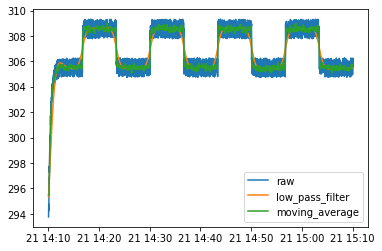

In [23]:
plt.close()
tsd = data_types.TimeSeriesData(save_path, key="test")
plt.plot(tsd["measured_T"])
plt.legend(tsd["measured_T"].columns.values)
plt.show()

Let's get a closer look at the DataFrame-Object.

We now have two variables, the measured temperature and the created signal. Furthermore we created new tags, allowing us to always recap where our data came from.

In [24]:
tsd

Variables            measured_T                                 \
Tags                        raw low_pass_filter moving_average   
Time                                                             
2019-12-21 14:10:03  293.764306      295.362644     295.485683   
2019-12-21 14:10:04  294.581815      295.508527     295.485683   
2019-12-21 14:10:05  294.757593      295.655329     295.485683   
2019-12-21 14:10:06  294.236406      295.802966     295.485683   
2019-12-21 14:10:07  294.995937      295.951354     295.485683   
...                         ...             ...            ...   
2019-12-21 15:10:00  305.029739      305.493348     305.582428   
2019-12-21 15:10:01  306.215838      305.493561     305.582428   
2019-12-21 15:10:02  305.805173      305.493745     305.582428   
2019-12-21 15:10:03  306.255180      305.493902     305.582428   
2019-12-21 15:10:03  305.630872      305.494034     305.582428   

Variables               Device_Input  
Tags                converted_signal  
Time                                  
2019-12-21 14:10:03              0.0  
2019-12-21 14:10:04              0.0  
2019-12-21 14:10:05              0.0  
2019-12-21 14:10:06              0.0  
2019-12-21 14:10:07              0.0  
...                              ...  
2019-12-21 15:10:00              0.0  
2019-12-21 15:10:01              0.0  
2019-12-21 15:10:02              0.0  
2019-12-21 15:10:03              0.0  
2019-12-21 15:10:03              0.0  

[3610 rows x 4 columns]

As you may have noticed, the measurement was made for 1 hour with a 1 second interval. Let's assume you want to run the simulation with a bigger time-interval. To not only use the data, but at a later stage also compare results, the `preprocessing` module holds a function for you.
`clean_and_space_equally_time_series` Takes your data and resamples it to the desired frequency. Try different inputs, like "1s", "30s", "2min", "1h" or others.

- Be aware that **upsampling** your data is to create artificial values. In contrast, **downsampling** is a valid and secure method.
- See [here](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases) for allowed frequencies like "15min".

In [25]:
tsd.clean_and_space_equally(desired_freq="1min")
tsd

D:\Python\anaconda3\envs\ebcpy\lib\site-packages\scipy\stats\_distn_infrastructure.py:2098: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
D:\Python\anaconda3\envs\ebcpy\lib\site-packages\scipy\stats\_distn_infrastructure.py:2099: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Variables            measured_T                                 \
Tags                        raw low_pass_filter moving_average   
2019-12-21 14:10:03  293.764306      295.362644     295.485683   
2019-12-21 14:11:03  304.571352      302.967651     304.168432   
2019-12-21 14:12:03  304.772792      305.761296     305.299445   
2019-12-21 14:13:03  304.867753      305.730389     305.544055   
2019-12-21 14:14:03  304.970765      305.487325     305.462056   
...                         ...             ...            ...   
2019-12-21 15:06:03  304.991349      305.410694     305.272184   
2019-12-21 15:07:03  306.015593      305.469788     305.551311   
2019-12-21 15:08:03  305.844088      305.472332     305.409083   
2019-12-21 15:09:03  305.471418      305.447115     305.416989   
2019-12-21 15:10:03  305.029739      305.493348     305.582428   

Variables               Device_Input  
Tags                converted_signal  
2019-12-21 14:10:03              0.0  
2019-12-21 14:11:03              0.0  
2019-12-21 14:12:03              0.0  
2019-12-21 14:13:03              0.0  
2019-12-21 14:14:03              0.0  
...                              ...  
2019-12-21 15:06:03              0.0  
2019-12-21 15:07:03              0.0  
2019-12-21 15:08:03              0.0  
2019-12-21 15:09:03              0.0  
2019-12-21 15:10:03              0.0  

[61 rows x 4 columns]

# Conversion

Now let's get to the simulation part. If you are familiar with **Modelica**, you know *inputs from files* may either be in `.txt` or `.mat` format. Both options are supported in `ebcpy`.

Let's take our preprocessed data and convert it to first to .txt, then to .mat:

In [26]:
from ebcpy.utils import conversion

file_path = os.path.join(os.getcwd(), "tutorial", "measuredData_preprocessed.hdf")

success, save_path_txt = conversion.convert_hdf_to_modelica_txt(filepath=file_path,
                                                                table_name="Simulation_Input",
                                                                # Lets use the default save-path
                                                                save_path_file=None,  
                                                                # = [], = [("measured_T", "moving_average")] o.s. is also possible.
                                                                columns=["Device_Input"],
                                                                key="test",
                                                                # Rerun the cell and change values 
                                                                # below to understand these args.
                                                                offset=0, 
                                                                sep="\t")

# Let's print the first 15 lines to understand the result. 
# Simulation_Input is the table_name. 
# The tag is added to the varialbe
print("".join(open(save_path_txt, "r").readlines()[:15]))

#1
double Simulation_Input(3610, 2)
#time_in_s	Device_Input_converted_signal
0.0	0.0
1.0	0.0
2.0	0.0
3.0	0.0
4.0	0.0
5.0	0.0
6.0	0.0
7.0	0.0
8.0	0.0
9.0	0.0
10.0	0.0
11.0	0.0



In [27]:
conversion.convert_hdf_to_modelica_mat(filepath=file_path,
                                       save_path_file=None,
                                       columns=[("measured_T", "moving_average")],
                                       key="test",
                                       offset=0)

(True,
 'D:\\Projects\\ebcpy\\ebcpy\\examples\\tutorial\\measuredData_preprocessed.mat')

# Dymola API

Now we will run a simulation using the `DymolaAPI`-Class. Make sure you have **Dymola** with a valid **license** installed on your machine to get this to run.

If you are new to the research at the EBC-Institute, the [**AixLib**](https://github.com/RWTH-EBC/AixLib) is a good  starting point for modelling. Most systems with regard to building energy systems have been already implemented.

In [28]:
from ebcpy.simulationapi import dymola_api
test_package = os.path.join(os.getcwd(), "Modelica", "TestModel.mo")

DYM_API = dymola_api.DymolaAPI(
                        # Used for saving simulation files etc.
                        cd=os.path.join(os.getcwd(), "data"),
                        # Name of the model you want to simulate
                        model_name="AixCalTest_TestModel",
                        # All package.mo files required
                        packages=[test_package],
                        # Whether the Dymola Window should be visible or not
                        show_window=True,
                        # Append structural parameters as modifiers to the
                        # Simulation
                        get_structural_parameters=True,
                        # Set the output as equidistant (Events are not stored)
                        equidistant_output=True,
                        # In some cases MemoryExceptions may occur after some 1000 simulations. 
                        # Restart dymola to free up space.
                        n_restart=2)

12.03.2021-09:09:06 INFO DymolaAPI: -------------------------Initializing class DymolaAPI-------------------------
12.03.2021-09:09:06 INFO DymolaAPI: -------------------------Initializing class DymolaAPI-------------------------
12.03.2021-09:09:06 INFO DymolaAPI: Open blank placeholder Dymola instance to ensure a licence during Dymola restarts
12.03.2021-09:09:06 INFO DymolaAPI: Open blank placeholder Dymola instance to ensure a licence during Dymola restarts
12.03.2021-09:09:23 INFO DymolaAPI: Loading Model Modelica
12.03.2021-09:09:23 INFO DymolaAPI: Loading Model Modelica
12.03.2021-09:09:24 INFO DymolaAPI: Loaded modules
12.03.2021-09:09:24 INFO DymolaAPI: Loaded modules


**Note:** If you have Dymola installed in an unusual path (e.g. on Windows outside of `C:\Program Files` (and for 64bit-systems `C:\Program Files (x86)`)) you have to provide the path of your dymola interface and the dymola-executable. Add the following kwargs to the code above to do so:

```python
dymola_api.DymolaAPI(
     cd=os.path.join(os.getcwd(), "data"),
     model_name="AixCalTest.TestModelInput",
     packages=[test_package],
     show_window=True,
     get_structural_parameters=True,
     equidistant_output=True,
     dymola_interface_path=r"PATH_TO_DYMOLA\Dymola 20XX\Modelica\Library\python_interface\dymola.egg",
     dymola_path=r"PATH_TO_DYMOLA\Dymola 20XX\bin64\Dymola.exe")
```


Before running our simulation, we have to understand the underlying model. 

<img src="tutorial\TestModelInput.png">

We have a simple Heat-Exchanger between two heaters. The heaters are basically pipes. For each pipe, a source set's the temperature and mass flow rate. The latter is provided as a constant parameter, either 0 or some fixed value, depending on a input signal. The signal turns the mass flow rate off if the value is greater than 0, representing an easy on-off control. To simulate our data, we have to add our input data to the `CombiTimeTable` so that Modelica knows where the input comes from. 

Now that we understand our model, we can simulate it. You can run this single simulation either through the API or directly in Dymola. The API is only handy for when you need to run lot's of simulations with different parameters (Calibration, Optimization).

When running the simulatiion with the `DymolaAPI` instance `DYM_API` a Dymola process is started (eventually just as a background process).

Let's run a simulation for one hour (3600 s) and look at the output:

In [32]:
sim_setup = {"startTime": 0,
             "stopTime": 3600}
# This simulation setup is equal to the simulation-setup window in Dymola.
# Look at the documentation to see what other parameters you may set.
DYM_API.set_sim_setup(sim_setup)

# Simulate the model. Note that there are different options at hand to get the simulation results. 
# See the docstring of the class for more information on that.
# We will use matfiles for now:
file_path_result = DYM_API.simulate(savepath_files="my_result.mat")

# Load the DataFrame and plot our variable of interest, in this case the pipe-Temperature.
tsd_sim = data_types.TimeSeriesData(file_path_result)
tsd.to_float_index()  # Convert the measured data to simulations (alternativ is to convert simulated data to datetime)
plt.plot(tsd_sim["heater1.heatPorts[1].T"].index, tsd_sim["heater1.heatPorts[1].T"].values, "r")
plt.plot(tsd.index, tsd[("measured_T", "moving_average")].values, "b")
plt.show()

KeyboardInterrupt: 

You may have noticed that our simulation is not equal to our measurement. 

To minimize the error between simulation and measurement, the EBC institute offers the python framework `AixCaliBuHa`. `AixCaliBuHa` offers different calibrators, all based on the `Optimizer` in `ebcpy`. The underlying data-structure is the `data_types` module.  
You find **`AixCaliBuHa`** [here](https://git.rwth-aachen.de/EBC/EBC_all/Optimization-and-Calibration/AixCaliBuHA)

To analyze `TimeSeriesData` and cluster or classify it, we refer to `EnStATS`, a library desgined to use Statistics and Machine Learning to analyze energy data.  
You find **`EnStATS`** [here](https://git.rwth-aachen.de/EBC/EBC_all/Optimization-and-Calibration/enstats).

# Optimization

As mentioned above, `ebcpy` provides an `Optimizer`. Primarily used for calibration. However, the optimizer is capable of solving other problems as well.

We offer an easy to use API for some open-source solvers (`scipy`, `dlib`) as well as own implementation of existings methods (to be done). 

**Note:** If you have a reoccuring task of optimization with a similar objective function, the use of this framework may make sense for you. If you just optimize once, this won't be much of a help. 

Let's assume we have some function and we want to approximate a quadratic formula to it.

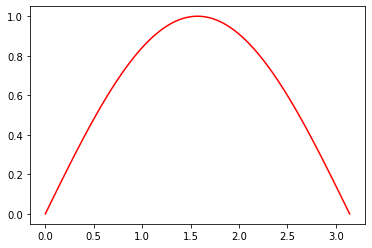

In [30]:
import numpy as np
# Generate array between 0 and pi
data = np.linspace(0, np.pi, 100)
goal = np.sin(data)
plt.plot(data, goal, "r")
plt.show()

Let's find the optimal parameters by creating our own Optimizer. You may want to pass own arguments to the class for usage in the objective. Just overwrite the `__init__` of the `Optimizer`. 
Depending on your use-case, you may want to pass `x0` and `bounds` as well. Some solvers don't require initial values. Boundaries are mostly required.

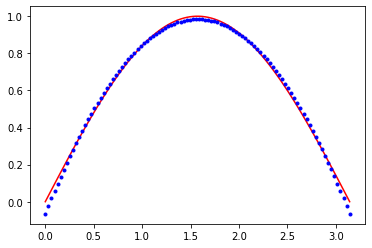

In [31]:
from ebcpy.optimization import Optimizer

class MyCustomOptimizer(Optimizer):

    # Our initial guesses (only scipy-minimize needs this)
    x0 = np.array([0, 0, 0])
    # Boundaries to our parameters.
    bounds = [(-100, 100), (-100, 100), (-100, 100)]

    def __init__(self, cd, goal, data, **kwargs):
        self.goal = goal
        self.data = data
        super().__init__(cd, **kwargs)

    def obj(self, xk, *args):
        # Calculate the quadratic formula:
        quadratic_func = xk[0] * self.data ** 2\
                            + xk[1] * self.data\
                            + xk[2]
        # Return the MAE of the quadratic function.
        return np.sum(np.abs(self.goal - quadratic_func))

mco = MyCustomOptimizer(cd=os.getcwd(),  # Used for the logger, we dont use this in this tutorial.
                        goal=goal,
                        data=data)

res = mco.optimize(framework="scipy_differential_evolution", method="best1bin")
plt.plot(data, goal, "r")
plt.plot(data, res.x[0] * data ** 2 + res.x[1] * data + res.x[2], "b.")
plt.show()

**If you have any questions or encounter bugs, please feel free to [raise an issue](https://git.rwth-aachen.de/EBC/EBC_all/Python/ebcpy/issues)! We hope this tutorial made the use case and usage of `ebcpy` clear to you. We also refer to the python examples in the examples folder. Here you can also test the objects within in the framework.**